# ACTIVIDAD 5 | VISUALIZACIÓN DE RESULTADOS

ANÁLISIS DE GRANDES VOLÚMENES DE DATOS


Miguel Ángel Loya Tarango A01796407

Jorge Andrés Santos Gordon A01652587

César Iván Herrera Martínez A01796392

José María Blancas Ortiz A01363436

# Descarga de la base y obtención de df

In [ ]:
!pip install -q kaggle pyspark

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jorgesantosgordon","key":"6f4e8efece04cc5d84f1763b7e300f2c"}'}

In [ ]:
from pyspark.sql.functions import col, round

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jakewright/9000-tickers-of-stock-market-data-full-history -p /content/dataset --unzip                 #Descarga de base de 9000 tickers del mercado de EU a través de kaggle

Dataset URL: https://www.kaggle.com/datasets/jakewright/9000-tickers-of-stock-market-data-full-history
License(s): other
 99% 1.77G/1.79G [00:18<00:00, 228MB/s]
100% 1.79G/1.79G [00:18<00:00, 103MB/s]


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("KaggleData").getOrCreate()

In [ ]:
df = spark.read.csv("/content/dataset/all_stock_data.csv", header=True, inferSchema=True)
df.show(5)

+----------+------+----+-------------------+-------------------+-------------------+---------+---------+------------+
|      Date|Ticker|Open|               High|                Low|              Close|   Volume|Dividends|Stock Splits|
+----------+------+----+-------------------+-------------------+-------------------+---------+---------+------------+
|1962-01-02|    ED| 0.0| 0.2658275556233194|0.26178762316703796|0.26178762316703796|  25600.0|      0.0|         0.0|
|1962-01-02|   CVX| 0.0|0.04680890217423439|0.04606926600933256|0.04680890217423439| 105840.0|      0.0|         0.0|
|1962-01-02|    GD| 0.0|0.21003275954390174|0.20306070787008793| 0.2082897424697876|2648000.0|      0.0|         0.0|
|1962-01-02|    BP| 0.0|0.14143933090345925|0.13952797651290894|0.13952797651290894|  77440.0|      0.0|         0.0|
|1962-01-02|   MSI| 0.0| 0.7649229763450202| 0.7452535214492476| 0.7518101930618286|  65671.0|      0.0|         0.0|
+----------+------+----+-------------------+------------

In [ ]:
df = df.na.drop(subset=["Close", "Volume","Open", "High", "Low", "Dividends", "Stock Splits"])                  #Eliminación de valores nulos en columnas relevantes

In [ ]:
columnas = ["Close", "Volume"]                                                                                  #Columnas relevantes para análisis y estratificación
qs = [0.25, 0.75]

percentiles = {}
for columna in columnas:
    percentiles[columna] = df.approxQuantile(columna, qs, 0.01)

In [ ]:
from pyspark.sql.functions import col, round, when, row_number

Q1Close, Q3Close = percentiles["Close"]
IQRClose = Q3Close - Q1Close
LowClose = Q1Close - 1.5 * IQRClose
HighClose = Q3Close + 1.5 * IQRClose

Q1Volume, Q3Volume = percentiles["Volume"]
IQRVolume = Q3Volume - Q1Volume
LowVolume = Q1Volume - 1.5 * IQRVolume
HighVolume = Q3Volume + 1.5 * IQRVolume

nooutliersdf = df.filter((col("Close") >= LowClose) & (col("Close") <= HighClose) &(col("Volume") >= LowVolume) & (col("Volume") <= HighVolume))

**De acuerdo con la exploración realizada anteriormente, definimos los siguientes grupos de caracterización:**

***Close***

*   **C1: Valores menores a 5**
*   **C2: Valores entre 5 y 25**
*   **C3: Valores mayores a 25**

***Volume***

*   **V1: Valores mayores a 100,000**
*   **V2: Valores menores a 100,000**

**Con esto, generamos 6 particiones con las diferentes combinaciones:**

*   **C1 y V1**
*   **C1 y V2**
*   **C2 y V1**
*   **C2 y V2**
*   **C3 y V1**
*   **C3 y V2**

**Para poder hacer una partición con base en estas categorías, agregamos una columna al dataframe que incluya el marcador al que combinación pertenece cada registro**

In [ ]:
dfStrata = nooutliersdf.withColumn(                                                                        #Creación de columna para estratificación por muestreo entre volumen y precio de cierre
    "strata",
    when((col("Close")  < 5) & (col("Volume") >=100000), "C1V1")
    .when((col("Close")  < 5) & (col("Volume") < 100000), "C1V2")
    .when(((col("Close") >= 5) & (col("Close") <= 25)) & (col("Volume") >=100000), "C2V1")
    .when(((col("Close") >= 5) & (col("Close") <= 25)) & (col("Volume") < 100000), "C2V2")
    .when((col("Close") > 25) & (col("Volume") >=100000), "C3V1")
    .otherwise("C3V2")
)

dfStrata.show()

+----------+------+-------------------+--------------------+--------------------+--------------------+--------+---------+------------+------+
|      Date|Ticker|               Open|                High|                 Low|               Close|  Volume|Dividends|Stock Splits|strata|
+----------+------+-------------------+--------------------+--------------------+--------------------+--------+---------+------------+------+
|1962-01-02|    ED|                0.0|  0.2658275556233194| 0.26178762316703796| 0.26178762316703796| 25600.0|      0.0|         0.0|  C1V2|
|1962-01-02|   CVX|                0.0| 0.04680890217423439| 0.04606926600933256| 0.04680890217423439|105840.0|      0.0|         0.0|  C1V1|
|1962-01-02|    BP|                0.0| 0.14143933090345925| 0.13952797651290894| 0.13952797651290894| 77440.0|      0.0|         0.0|  C1V2|
|1962-01-02|   MSI|                0.0|  0.7649229763450202|  0.7452535214492476|  0.7518101930618286| 65671.0|      0.0|         0.0|  C1V2|
|1962-

# Construcción de k-folds

Utilizamos la muestra estratificada que definimos en la actividad anterior y utilizamos sampleBy para mantener cierta representatividad en cada partición de la población original, haciendo que cada fold tenga una distribución similar al dataset total.

In [ ]:
fractions = {"C1V1": 0.02, "C1V2": 0.02, "C2V1": 0.02, "C2V2": 0.02, "C3V1": 0.02, "C3V2": 0.02}                   #Fracciones para muestreo con distribución similar

M = dfStrata.sampleBy("strata", fractions=fractions, seed=42)
M.show()

+----------+------+-------------------+--------------------+--------------------+--------------------+--------+---------+------------+------+
|      Date|Ticker|               Open|                High|                 Low|               Close|  Volume|Dividends|Stock Splits|strata|
+----------+------+-------------------+--------------------+--------------------+--------------------+--------+---------+------------+------+
|1962-01-02|    BA|0.19031055781074385| 0.19031055781074385| 0.18703724443912506| 0.18703724443912506|352350.0|      0.0|         0.0|  C1V1|
|1962-01-08|    KR|                0.0|0.030283647329133908|0.029257083012892083|0.030155334621667862|208000.0|      0.0|         0.0|  C1V1|
|1962-01-08|   HPQ|0.04285311000598342|0.043499965220689774| 0.04204436372270773|0.043499965220689774|873754.0|      0.0|         0.0|  C1V1|
|1962-01-11|   HON|                0.0|   1.556136827268702|  1.5351078884783917|  1.5526320934295654| 46751.0|      0.0|         0.0|  C1V2|
|1962-

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.window import Window

import numpy as np

assemblerM = VectorAssembler(inputCols=["Open", "High", "Low"], outputCol="features")
processedM = assemblerM.transform(M).select("features", "Close", "strata")

In [ ]:
from pyspark.sql.functions import rand

k = 5
w = Window.partitionBy("strata").orderBy(rand())
Mindex = processedM.withColumn("NumCol", row_number().over(w))
Mindex.show()

+--------------------+------------------+------+------+
|            features|             Close|strata|NumCol|
+--------------------+------------------+------+------+
|[11.6099996566772...|12.399999618530273|  C2V1|     1|
|[22.25,22.5900001...|22.229999542236328|  C2V1|     2|
|[23.1017093658447...|23.101709365844727|  C2V1|     3|
|[22.2900009155273...|23.329999923706055|  C2V1|     4|
|[15.7600002288818...|15.789999961853027|  C2V1|     5|
|[17.8899993896484...|18.280000686645508|  C2V1|     6|
|[17.3790626525878...| 17.37906265258789|  C2V1|     7|
|[16.4899997711181...|16.639999389648438|  C2V1|     8|
|[9.27000045776367...| 9.149999618530273|  C2V1|     9|
|[17.0162804334780...|17.157577514648438|  C2V1|    10|
|[18.0599994659423...| 18.40999984741211|  C2V1|    11|
|[6.63000011444091...| 6.480000019073486|  C2V1|    12|
|[15.0,16.35000038...|16.299999237060547|  C2V1|    13|
|[19.2692823335917...|19.659143447875977|  C2V1|    14|
|[23.7296287267178...|23.788291931152344|  C2V1|

# Definición de proceso de validación cruzada

Seleccionamos un valor de k para generar equilibrio entre la representatividad y el esfuerzo compitacional.

La columna fold se genera asignando a cada registro un fold de manera balanceada y eso garantiza que cada fold sea representativo de la población original estratificada (que fue el método que planteamos desde el inicio)

En este caso, utilizamos un valor de k=5 para la validación cruzada, ya que permite generar conjuntos de train y test con una relación de 80% - 20%, similar al que se utilizó en las actividades anteriores.

Aunque la muestra sea una fracción de todo el data set, sigue siendo un conjunto grande, por lo que valores altos de k implican un costo computacional muy alto. El k=5 ofrece un balance entre validación robusta y desempeño del sistema.

El valor de 5 es utilizado de manera estándar en análisis de datos, y es suficiente para capturar la variabilidad de los datos, y detectar si en alguna iteración el modelo se está sobre o subajustando a los mismos.

Estos puntos nos permitirán obtener un buen panorama del desempeño del modelo, sin sesgarlo a cierto sector de los datos.

In [ ]:
Mfolds = Mindex.withColumn("Fold", (col("NumCol") % k).cast("int"))
Mfolds.show()

+--------------------+------------------+------+------+----+
|            features|             Close|strata|NumCol|Fold|
+--------------------+------------------+------+------+----+
|[11.6099996566772...|12.399999618530273|  C2V1|     1|   1|
|[22.25,22.5900001...|22.229999542236328|  C2V1|     2|   2|
|[23.1017093658447...|23.101709365844727|  C2V1|     3|   3|
|[22.2900009155273...|23.329999923706055|  C2V1|     4|   4|
|[15.7600002288818...|15.789999961853027|  C2V1|     5|   0|
|[17.8899993896484...|18.280000686645508|  C2V1|     6|   1|
|[17.3790626525878...| 17.37906265258789|  C2V1|     7|   2|
|[16.4899997711181...|16.639999389648438|  C2V1|     8|   3|
|[9.27000045776367...| 9.149999618530273|  C2V1|     9|   4|
|[17.0162804334780...|17.157577514648438|  C2V1|    10|   0|
|[18.0599994659423...| 18.40999984741211|  C2V1|    11|   1|
|[6.63000011444091...| 6.480000019073486|  C2V1|    12|   2|
|[15.0,16.35000038...|16.299999237060547|  C2V1|    13|   3|
|[19.2692823335917...|19

# Fase de entrenamiento

Se utiliza un loop de entrenamiento para cada fold. Seleccionamos un modelo de regresión lineal (de PySpark MLlib), que fue el algoritmo seleccionado en la Actividad 4 por su capacidad para modelar relaciones lineales entre las variables y el precio de cierre (Close).

En cada iteración del proceso de validación cruzada k-fold, el modelo fue entrenado con los k-1 folds restantes, y evaluado con el fold correspondiente.
Las métricas de calidad del modelo se registraron a partir de la raíz cuadrada del error cuadrático medio (RMSE) y el coeficiente de determinación (R²), siguiendo las métricas seleccionadas en la actividad 4, para evaluar la capacidad de generalización del modelo.

In [ ]:
rmse_results = []
r2_results = []

for i in range(k):
    print(f"Fold {i+1}/{k}")

    train = Mfolds.filter(col("Fold") != i).select("features", "Close")                                    #Target para predicción de la variable close
    test = Mfolds.filter(col("fold") == i).select("features", "Close")

    lr = LinearRegression(featuresCol="features", labelCol="Close",
      maxIter=100,
      regParam=0.1,
      elasticNetParam=0.0,
      tol=1e-6,
      fitIntercept=True)

    lr_model = lr.fit(train)

    predictions = lr_model.transform(test)
    evaluator = lr_model.evaluate(test)

    rmse = evaluator.rootMeanSquaredError
    r2 = evaluator.r2
    print("RMSE:", rmse)
    print("R²:", r2)

    rmse_results.append(rmse)
    r2_results.append(r2)

Fold 1/5
RMSE: 1.110879271189774
R²: 0.9932871655355995
Fold 2/5
RMSE: 0.4305509104812057
R²: 0.999012518657911
Fold 3/5
RMSE: 0.5476430740571192
R²: 0.9983944965299862
Fold 4/5
RMSE: 0.4375351968688621
R²: 0.9989713841570425
Fold 5/5
RMSE: 0.627414390679048
R²: 0.997874824410057


In [ ]:
rmse_avg = np.mean(rmse_results)
r2_avg = np.mean(r2_results)
rmse_std = np.std(rmse_results)
r2_std = np.std(r2_results)

print("Resultados Finales (K-Fold Estratificado por '{}')".format("strata"))
print("Promedio RMSE:", rmse_avg)
print("Desviación Estándar RMSE:", rmse_std)
print("Promedio R²:", r2_avg)
print("Desviación Estándar R²:", r2_std)

Resultados Finales (K-Fold Estratificado por 'strata')
Promedio RMSE: 0.6308045686552018
Desviación Estándar RMSE: 0.25093968406248895
Promedio R²: 0.9975080778581192
Desviación Estándar R²: 0.0021513228197617474


# Visualización de resultados

La gráfica resultante logró demostrar el comportamiento de las métricas de desempeño (RMSE y R²) para cada uno de los 5 folds utilizados en el proceso de validación cruzada.

El modelo presenta una R² alta, lo que nos indica que es capaz de explicar casi toda la variabilidad de la variable 'Close'.
El RMSE muestra cierta variabilidad entre folds, pero indica un buen desempeño al momento de predecir.
El desempeño de los folds se ve homologado, lo que sugiere que la partición de los folds fue adecuada ya que es representativa.

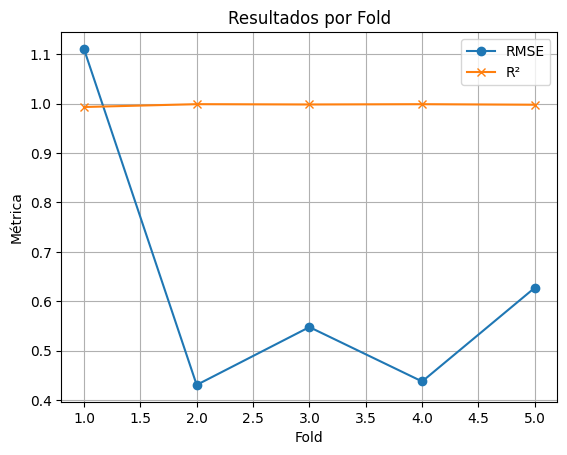

RMSE promedio: 0.6308045686552018
R² promedio: 0.9975080778581192


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, k+1), rmse_results, marker='o', label='RMSE')
plt.plot(range(1, k+1), r2_results, marker='x', label='R²')
plt.title("Resultados por Fold")
plt.xlabel("Fold")
plt.ylabel("Métrica")
plt.legend()
plt.grid(True)
plt.show()

print("RMSE promedio:", sum(rmse_results)/k)
print("R² promedio:", sum(r2_results)/k)

# Discusión y conclusiones

En esta actividad se implementó un proceso de validación cruzada k-fold para evaluar la eficiencia del modelo entrenado en un contexto de big data. El muestreo estratificado nos permitió hacer que los folds fueran representativos de la población original, asegurando así una evaluación correcta.

Se utilizó un k=5, ya que buscamos un equilibrio entre el rendimiento y la necesidad de capturar la variabilidad del modelo. Los resultados mostraron una baja variabilidad en las métricas (RMSE y R²), lo cual sugiere que el modelo de regresión lineal tiene una buena capacidad de generalización en este escenario. Es importante destacar que aunque los folds se generaron tomando como base la caracterización de los daots, sigue habiendo rangos y variabilidad dentro de los mismos, por lo que se espera que las métricas tengan fluctuaciones entre iteraciones del modelo.

El poder ver cómo se genera consistencia entre folds hace que en esta actividad logremos ver de manera contundente cómo el generar submuestreos o muestras acotadas, realmente nos lleva a resultados certeros sin necesidad de extraer toda la información al momento de entrenar nuestros modelos.

El uso de PySpark fue clave para manejar el volumen de datos de forma eficiente, permitiendo que el proceso de validación cruzada fuera viable sin comprometer recursos. En general, ahora sabemos que, con las herramientas adecuadas, la validación cruzada es una técnica bastante útil para Big Data, dándonos la seguridad necesaria para poder escalar los modelos en el momento en que se requiera.

